In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import h5py


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print(f"GPU Detected: {gpu.device_type} - {gpu.name}")
else:
    print("No GPU detected")

GPU Detected: GPU - /physical_device:GPU:0
GPU Detected: GPU - /physical_device:GPU:1


# All data

In [56]:
# Open the HDF5 file
hdf5_file = 'processed_images_all.hdf5'
with h5py.File(hdf5_file, 'r') as file:
    # Read the test labels dataset into a numpy array
    test_labels = file['test_images_labels'][:]

# Create a DataFrame from the labels
test_labels = pd.DataFrame(test_labels, columns=['label'])

test_labels = test_labels['label'].to_numpy()
test_labels.shape

(3574,)

## Inspect images file content

In [4]:
# Function to inspect the contents of an HDF5 file
def inspect_hdf5_file(filepath):
    # Open the HDF5 file
    with h5py.File(filepath, 'r') as file:
        print("Datasets contained within the file:")
        for dataset_name in file:
            # Access the dataset
            dataset = file[dataset_name]
            # Print details about the dataset
            print(f"Dataset Info: {dataset_name}, {dataset.shape}, {dataset.dtype}")

# Call the function to inspect the HDF5 file
inspect_hdf5_file(hdf5_file)

Datasets contained within the file:
Dataset Info: test_images, (3574, 224, 224, 3), float64
Dataset Info: test_images_labels, (3574,), int32
Dataset Info: train_images, (28561, 224, 224, 3), float64
Dataset Info: train_images_labels, (28561,), int32
Dataset Info: valid_images, (3579, 224, 224, 3), float64
Dataset Info: valid_images_labels, (3579,), int32


## Image generator function

In [5]:
# Define a generator function to load images from the HDF5 file
def hdf5_image_generator(filepath, dataset_name, batch_size):
    while True:  # Loop indefinitely
        with h5py.File(filepath, 'r') as file:
            images = file[dataset_name]
            labels = file[dataset_name + '_labels']  # Adjust if your labels are stored differently
            num_samples = images.shape[0]

            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                yield images[start:end], labels[start:end]

batch_size = 32

# Create generators for training and validation
train_generator = hdf5_image_generator(hdf5_file, 'train_images', batch_size)
valid_generator = hdf5_image_generator(hdf5_file, 'valid_images', batch_size)
test_generator = hdf5_image_generator(hdf5_file, 'test_images', batch_size)

# Get the lengths of the datasets
def get_dataset_lengths(filepath):
    with h5py.File(filepath, 'r') as file:
        lengths = {}
        for dataset_name in file:
            dataset = file[dataset_name]
            lengths[dataset_name] = len(dataset)
    return lengths

dataset_lengths = get_dataset_lengths(hdf5_file)
train_steps_per_epoch = dataset_lengths['train_images'] // batch_size
valid_steps = dataset_lengths['valid_images'] // batch_size
test_steps = (dataset_lengths['test_images'] + batch_size - 1) // batch_size

## Early stopping callback

In [6]:
# Implement EarlyStopping callback function
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Log when training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

## Model

In [8]:
# Load ResNet50 model, similar adjustments as VGG16
resnet50_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = Flatten()(resnet50_base_model.output)

x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

output = Dense(10, activation='softmax')(x)

resnet50_model = Model(inputs=resnet50_base_model.input, outputs=output)
resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [9]:
# Fit the model
resnet50_model_history = resnet50_model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,
    batch_size=32,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[early_stopping]  # Include the early stopping callback
)

Epoch 1/50


2024-05-15 16:12:57.179029: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8907
2024-05-15 16:12:57.703760: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fd608f8ea10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-15 16:12:57.703786: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN V, Compute Capability 7.0
2024-05-15 16:12:57.703791: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2024-05-15 16:12:57.710263: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-15 16:12:57.792958: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


892/892 [==============================] - 350s 367ms/step - loss: 1.6899 - accuracy: 0.5004 - val_loss: 2.7245 - val_accuracy: 0.4899
Epoch 2/50
892/892 [==============================] - 387s 433ms/step - loss: 1.0395 - accuracy: 0.6602 - val_loss: 1.3113 - val_accuracy: 0.5856
Epoch 3/50
892/892 [==============================] - 371s 417ms/step - loss: 0.8971 - accuracy: 0.7006 - val_loss: 1.1567 - val_accuracy: 0.6540
Epoch 4/50
892/892 [==============================] - 360s 403ms/step - loss: 0.8163 - accuracy: 0.7243 - val_loss: 1.3421 - val_accuracy: 0.6458
Epoch 5/50
892/892 [==============================] - 348s 391ms/step - loss: 0.7641 - accuracy: 0.7393 - val_loss: 1.4741 - val_accuracy: 0.6092
Epoch 6/50
892/892 [==============================] - 356s 400ms/step - loss: 0.7161 - accuracy: 0.7552 - val_loss: 2.7483 - val_accuracy: 0.6506
Epoch 7/50
892/892 [==============================] - 346s 388ms/step - loss: 0.6579 - accuracy: 0.7745 - val_loss: 1.9992 - val_accura

### Save model

In [10]:
resnet50_model.save('models/resnet50_model_all.keras')

### Load model

In [11]:
# Load the model from the .h5 file
#resnet50_model = load_model('models/resnet50_model_all.keras')

### Evaluate

In [12]:
# Perform evaluation
test_loss, test_acc = resnet50_model.evaluate(test_generator, steps=test_steps)
print("ResNet50 Model Test Accuracy:", test_acc)

112/112 [==============================] - 51s 442ms/step - loss: 1.1934 - accuracy: 0.6469
ResNet50 Model Test Accuracy: 0.6468942165374756


### Plot

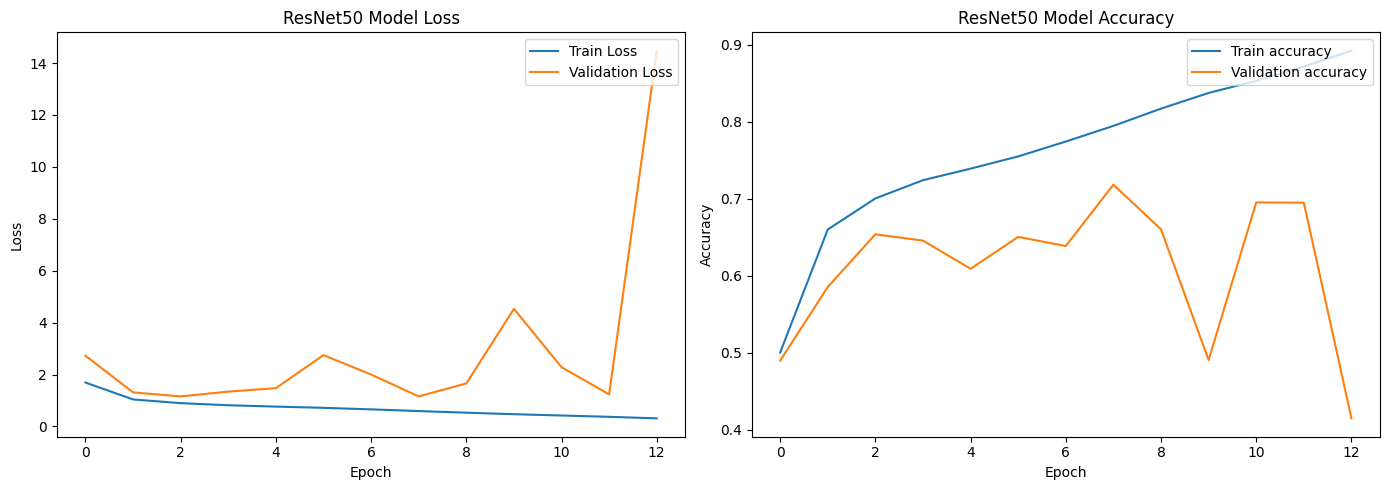

In [13]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(resnet50_model_history.history['loss'], label='Train Loss')
plt.plot(resnet50_model_history.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(resnet50_model_history.history['accuracy'], label='Train accuracy')
plt.plot(resnet50_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [57]:
predictions = resnet50_model.predict(test_generator, steps=test_steps)
predicted_labels = np.argmax(predictions, axis=1)
test_labels, predicted_labels

112/112 [==============================] - 29s 246ms/step


(array([7, 3, 0, ..., 4, 1, 3], dtype=int32), array([4, 1, 2, ..., 0, 0, 3]))

In [59]:
accuracy = accuracy_score(test_labels, predicted_labels)
print("ResNet50 Model Accuracy:", accuracy)

ResNet50 Model Accuracy: 0.2344711807498601


### Confusion Matrix

ResNet50 Model Confusion Matrix:
 [[443 398 125 127 169   0   0   0   0   0]
 [316 292 110  88 122   0   0   0   0   0]
 [145 143  41  44  71   0   0   0   0   0]
 [134 149  54  48  59   0   0   0   0   0]
 [113  90  34  33  55   0   0   0   0   0]
 [  8   7   3   3   2   0   0   0   0   0]
 [ 33  26   7  10  17   0   0   0   0   0]
 [  6  11   4   3   3   0   0   0   0   0]
 [ 12   9   3   1   2   0   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   0]]


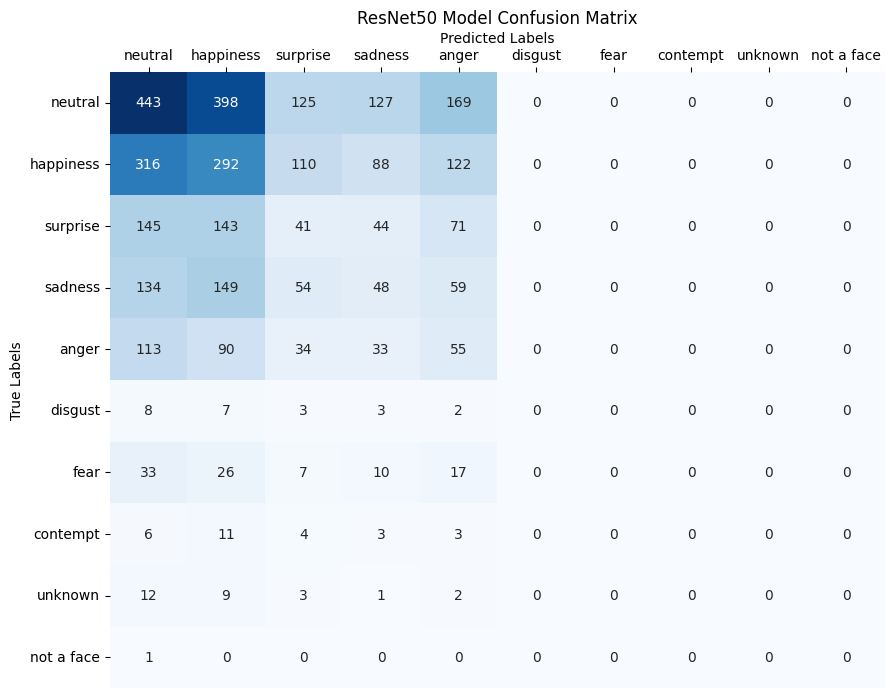

In [24]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
    5: "disgust",
    6: "fear",
    7: "contempt",
    8: "unknown",
    9: "not a face"
}

# Get the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)
print("ResNet50 Model Confusion Matrix:\n", conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('ResNet50 Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()

# Balanced data

In [25]:
# Open the HDF5 file
hdf5_file = 'processed_images_balanced.hdf5'
with h5py.File(hdf5_file, 'r') as file:
    # Read the test labels dataset into a numpy array
    balanced_test_labels = file['test_images_labels'][:]

# Create a DataFrame from the labels
balanced_test_labels = pd.DataFrame(balanced_test_labels, columns=['label'])

balanced_test_labels.shape

(2103, 1)

## Inspect images file content

In [26]:
# Function to inspect the contents of an HDF5 file
def inspect_hdf5_file(filepath):
    # Open the HDF5 file
    with h5py.File(filepath, 'r') as file:
        print("Datasets contained within the file:")
        for dataset_name in file:
            # Access the dataset
            dataset = file[dataset_name]
            # Print details about the dataset
            print(f"Dataset Info: {dataset_name}, {dataset.shape}, {dataset.dtype}")

# Call the function to inspect the HDF5 file
inspect_hdf5_file(hdf5_file)

Datasets contained within the file:
Dataset Info: test_images, (2103, 224, 224, 3), float64
Dataset Info: test_images_labels, (2103,), int32
Dataset Info: train_images, (16981, 224, 224, 3), float64
Dataset Info: train_images_labels, (16981,), int32
Dataset Info: valid_images, (2121, 224, 224, 3), float64
Dataset Info: valid_images_labels, (2121,), int32


## Image generator function

In [27]:
# Define a generator function to load images from the HDF5 file
def hdf5_image_generator(filepath, dataset_name, batch_size):
    while True:  # Loop indefinitely
        with h5py.File(filepath, 'r') as file:
            images = file[dataset_name]
            labels = file[dataset_name + '_labels']  # Adjust if your labels are stored differently
            num_samples = images.shape[0]

            for start in range(0, num_samples, batch_size):
                end = min(start + batch_size, num_samples)
                yield images[start:end], labels[start:end]

batch_size = 32

# Create generators for training and validation
balanced_train_generator = hdf5_image_generator(hdf5_file, 'train_images', batch_size)
balanced_valid_generator = hdf5_image_generator(hdf5_file, 'valid_images', batch_size)
balanced_test_generator = hdf5_image_generator(hdf5_file, 'test_images', batch_size)

# Get the lengths of the datasets
def get_dataset_lengths(filepath):
    with h5py.File(filepath, 'r') as file:
        lengths = {}
        for dataset_name in file:
            dataset = file[dataset_name]
            lengths[dataset_name] = len(dataset)
    return lengths

dataset_lengths = get_dataset_lengths(hdf5_file)
balanced_train_steps_per_epoch = dataset_lengths['train_images'] // batch_size
balanced_valid_steps = dataset_lengths['valid_images'] // batch_size
balanced_test_steps = (dataset_lengths['test_images'] + batch_size - 1) // batch_size

## Early stopping callback

In [28]:
# Implement EarlyStopping callback function
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor the validation loss
    patience=10,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Log when training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored metric
)

## Model

In [29]:
# Load the base model with pre-trained weights on ImageNet and without the top layer
balanced_resnet50_base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Flatten the output layer to 1 dimension
x = Flatten()(balanced_resnet50_base_model.output)

# Add a fully connected layer with 256 hidden units and ReLU activation
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Add a final softmax layer for classification
output = Dense(10, activation='softmax')(x)

# Configure and compile the model
balanced_resnet50_model = Model(inputs=balanced_resnet50_base_model.input, outputs=output)
balanced_resnet50_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Fit model

In [30]:
# Fit the model using the generator
balanced_resnet50_model_history = balanced_resnet50_model.fit(
    balanced_train_generator,
    steps_per_epoch=balanced_train_steps_per_epoch,
    epochs=50,
    validation_data=balanced_valid_generator,
    validation_steps=balanced_valid_steps,
    callbacks=[early_stopping]
)

Epoch 1/50
530/530 [==============================] - 267s 396ms/step - loss: 1.5155 - accuracy: 0.5425 - val_loss: 2.5321 - val_accuracy: 0.2055
Epoch 2/50
530/530 [==============================] - 316s 588ms/step - loss: 0.8732 - accuracy: 0.6610 - val_loss: 16.0154 - val_accuracy: 0.1913
Epoch 3/50
530/530 [==============================] - 221s 417ms/step - loss: 0.7657 - accuracy: 0.7099 - val_loss: 1.2867 - val_accuracy: 0.5966
Epoch 4/50
530/530 [==============================] - 153s 290ms/step - loss: 0.6511 - accuracy: 0.7490 - val_loss: 0.9514 - val_accuracy: 0.6577
Epoch 5/50
530/530 [==============================] - 204s 386ms/step - loss: 0.5812 - accuracy: 0.7742 - val_loss: 1.1483 - val_accuracy: 0.6345
Epoch 6/50
530/530 [==============================] - 137s 258ms/step - loss: 0.5316 - accuracy: 0.7949 - val_loss: 0.9177 - val_accuracy: 0.6813
Epoch 7/50
530/530 [==============================] - 167s 315ms/step - loss: 0.4813 - accuracy: 0.8129 - val_loss: 1.0348 

### Save model

In [31]:
balanced_resnet50_model.save('models/resnet50_model_balanced.keras')

### Load model

In [44]:
# Load the model from the .h5 file
balanced_resnet50_model = load_model('models/resnet50_model_balanced.keras')

### Evaluate

In [45]:
# Perform evaluation
balanced_test_loss, balanced_test_acc = balanced_resnet50_model.evaluate(balanced_test_generator, steps=balanced_test_steps)
print("ResNet50 Model Test Accuracy:", balanced_test_acc)

66/66 [==============================] - 57s 48ms/step - loss: 0.9454 - accuracy: 0.6538
ResNet50 Model Test Accuracy: 0.6538278460502625


### Plot

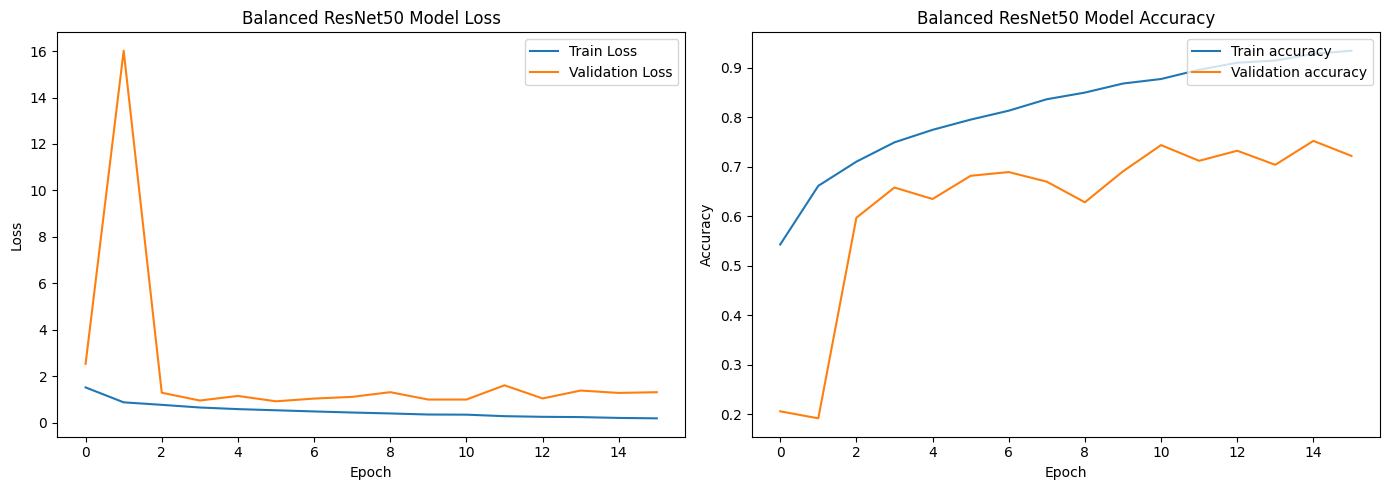

In [46]:
# Plot the history
# Assuming 'history' is the output from your model.fit()
plt.figure(figsize=(14, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(balanced_resnet50_model_history.history['loss'], label='Train Loss')
plt.plot(balanced_resnet50_model_history.history['val_loss'], label='Validation Loss')
plt.title('Balanced ResNet50 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation mean squared error
plt.subplot(1, 2, 2)
plt.plot(balanced_resnet50_model_history.history['accuracy'], label='Train accuracy')
plt.plot(balanced_resnet50_model_history.history['val_accuracy'], label='Validation accuracy')
plt.title('Balanced ResNet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [47]:
balanced_predictions = balanced_resnet50_model.predict(balanced_test_generator, steps=balanced_test_steps)
balanced_predicted_labels = np.argmax(balanced_predictions, axis=1)
balanced_test_labels, balanced_predicted_labels

66/66 [==============================] - 44s 118ms/step


(      label
 0         3
 1         2
 2         4
 3         0
 4         4
 ...     ...
 2098      3
 2099      0
 2100      4
 2101      1
 2102      3
 
 [2103 rows x 1 columns],
 array([3, 0, 2, ..., 1, 3, 0]))

In [48]:
# Get unique values and their counts
balanced_unique_values, balanced_counts = np.unique(balanced_predicted_labels, return_counts=True)

# Print unique values and counts
print("Unique values in predicted labels:", balanced_unique_values)
print("Counts of unique values in predicted labels:", balanced_counts)

Unique values in predicted labels: [0 1 2 3 4]
Counts of unique values in predicted labels: [764 343 424 303 269]


In [49]:
balanced_accuracy = accuracy_score(balanced_test_labels, balanced_predicted_labels)
print("ResNet50 Model Accuracy:", balanced_accuracy)

ResNet50 Model Accuracy: 0.20304327151688065


### Confusion Matrix

ResNet50 Model Confusion Matrix:
 [[166  84  85  63  64]
 [173  64  92  51  48]
 [165  64  93  70  52]
 [155  76  84  64  65]
 [105  55  70  55  40]]


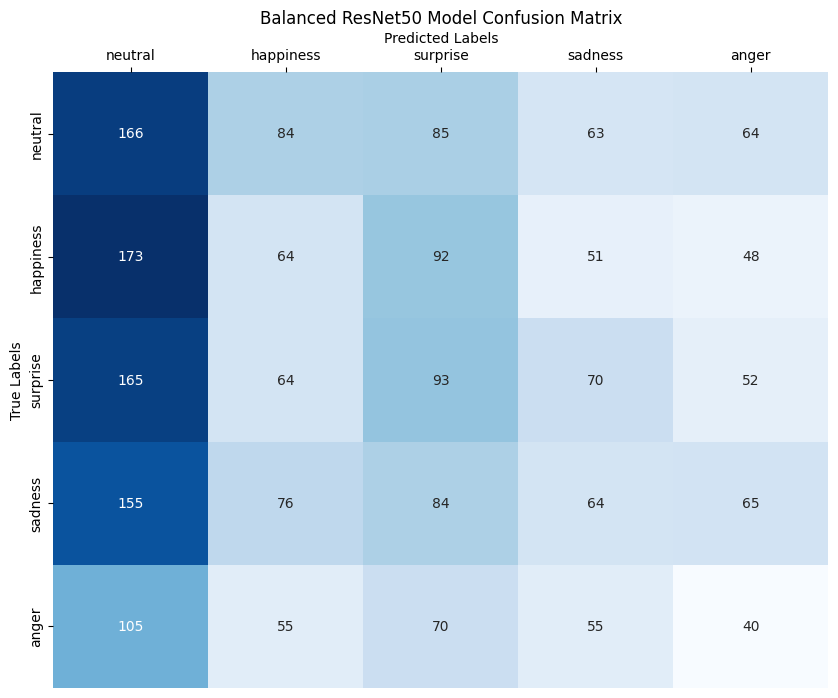

In [50]:
emotion_labels = {
    0: "neutral",
    1: "happiness",
    2: "surprise",
    3: "sadness",
    4: "anger",
}

# Get the confusion matrix
balanced_conf_matrix = confusion_matrix(balanced_test_labels, balanced_predicted_labels)
print("ResNet50 Model Confusion Matrix:\n", balanced_conf_matrix)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(balanced_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.values(), yticklabels=emotion_labels.values(), cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Balanced ResNet50 Model Confusion Matrix')

# Move the X-axis to the top of the plot
ax.xaxis.tick_top()  # X-axis on top
ax.xaxis.set_label_position('top')  # Move the x-axis label to the top

plt.show()